# 라이브러리

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt


In [2]:
import matplotlib.font_manager as fm
import matplotlib as mpl
font_path = './NanumGothicLight.otf'
fm.fontManager.addfont(font_path) 
mpl.rcParams['font.family'] = 'NanumGothicOTF'
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# 데이터

In [3]:
path_train = "/workspace/Storage/hansoldeco3/Data/raw/train.csv"
path_test = "/workspace/Storage/hansoldeco3/Data/raw/test.csv"
path_submission = "/workspace/Storage/hansoldeco3/Data/raw/sample_submission.csv"

In [4]:
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
submission = pd.read_csv(path_submission)

# 목적

검증 데이터 샘플링을 위한 분석

산출물 : 샘플 데이터

In [5]:
def preprocess_id(df):
    col = 'ID'
    df_ = df.copy()
    df_ = df_.set_index(col)
    return df_

def preprocess_datetime(s):
    d, m, t = s.split()
    dt = d+" "+t
    dt = datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M")
    if m == "오후" and dt.hour != 12:
        dt = dt + datetime.timedelta(hours = 12)
    return dt

def preprocess_dt(df, col):
    df_ = df.copy()
    df_[col] = df_[col].map(preprocess_datetime, na_action = 'ignore')
    return df_

def preprocess_tr(df):
    col1 = "사고인지 시간"
    col2 = "근무종류"
    df_ = df.copy()
    wttr = df_[col1].str.split('-', n=1, expand=True)
    wttr.columns = ['wt','tr']
    wt = wttr['wt']
    tr = wttr['tr']
    df_[col1] = tr.str.strip().replace('',np.nan)
    wt= wt.str.strip().replace('',np.nan)
    df_.insert(df.columns.get_loc(col1) + 1, col2, wt)
    return df_

def preprocess_temp_1(df):
    col = "기온"
    df_ = df.copy()
    df_[col] = df_[col].str.replace("℃","")
    df_[col].replace("", np.nan, inplace = True)
    df_[col] = df_[col].astype(float)
    return df_

def preprocess_humid_1(df):
    col = "습도"
    df_ = df.copy()
    df_[col] = df_[col].str.replace("%","")
    df_[col].replace("", np.nan, inplace = True)
    df_[col] = df_[col].astype(float)
    return df_

def preprocess_area_1(df):
    col = "연면적"
    df_ = df.copy()
    df_[col] = df_[col].str.replace(",","")
    df_[col] = df_[col].str.replace("㎡","")
    df_[col].replace("", np.nan, inplace = True)
    df_[col].replace("-", np.nan, inplace = True)
    df_[col] = df_[col].astype(float)
    return df_

def preprocess_floor_1(df):
    col = "층 정보"
    col1 = "지상"
    col2 = "지하"
    df_ = df.copy()
    df_[col].replace("-", np.nan, inplace = True)
    df_ = preprocess_hierarchy(df_, col, [col1, col2], sep = ",")
    
    df_[col1] = df_[col1].str.replace(r'\D', '', regex = True)
    df_[col2] = df_[col2].str.replace(r'\D', '', regex = True)

    df_[col1] = df_[col1].astype(float)
    df_[col2] = df_[col2].astype(float)
    return df_

def preprocess_cause_1(df):
    col = "사고원인"
    df_ = df.copy()
    df_[col] = df_[col].map(lambda x: np.nan if len(x)==1 else x, na_action = "ignore")
    return df_
    

def preprocess_hierarchy(df, col:str, levels:list, sep:str):
    level = len(levels)
    df_ = df.copy()
    frac = df_[col].str.split(sep, n=level-1, expand=True)
    frac.columns = levels
    frac = frac.apply(lambda x: x.str.strip())
    
    for i, column in enumerate(frac.columns):
        df_.insert(df.columns.get_loc(col) + i + 1, column, frac[column])
    df_.drop(col, axis=1, inplace = True)
    return df_



def pipeline1(df):
    df = preprocess_dt(df, "발생일시")
    df = preprocess_tr(df)
    df = preprocess_dt(df, "사고인지 시간")
    
    df = preprocess_temp_1(df)
    df = preprocess_humid_1(df)
    df = preprocess_area_1(df)
    df = preprocess_cause_1(df)
    df = preprocess_floor_1(df)
    df = preprocess_hierarchy(df, "공사종류", ["공사종류_대분류", "공사종류_중분류","공사종류_소분류"], "/")
    df = preprocess_hierarchy(df, "공종", ["공종_대분류", "공종_소분류"], ">")
    df = preprocess_hierarchy(df, "사고객체", ["사고객체_대분류", "사고객체_소분류"], ">")
    df = preprocess_hierarchy(df, "부위", ["부위1", "부위2"], "/")

    df = preprocess_id(df)
    return df

data = pipeline1(train)

<Axes: >

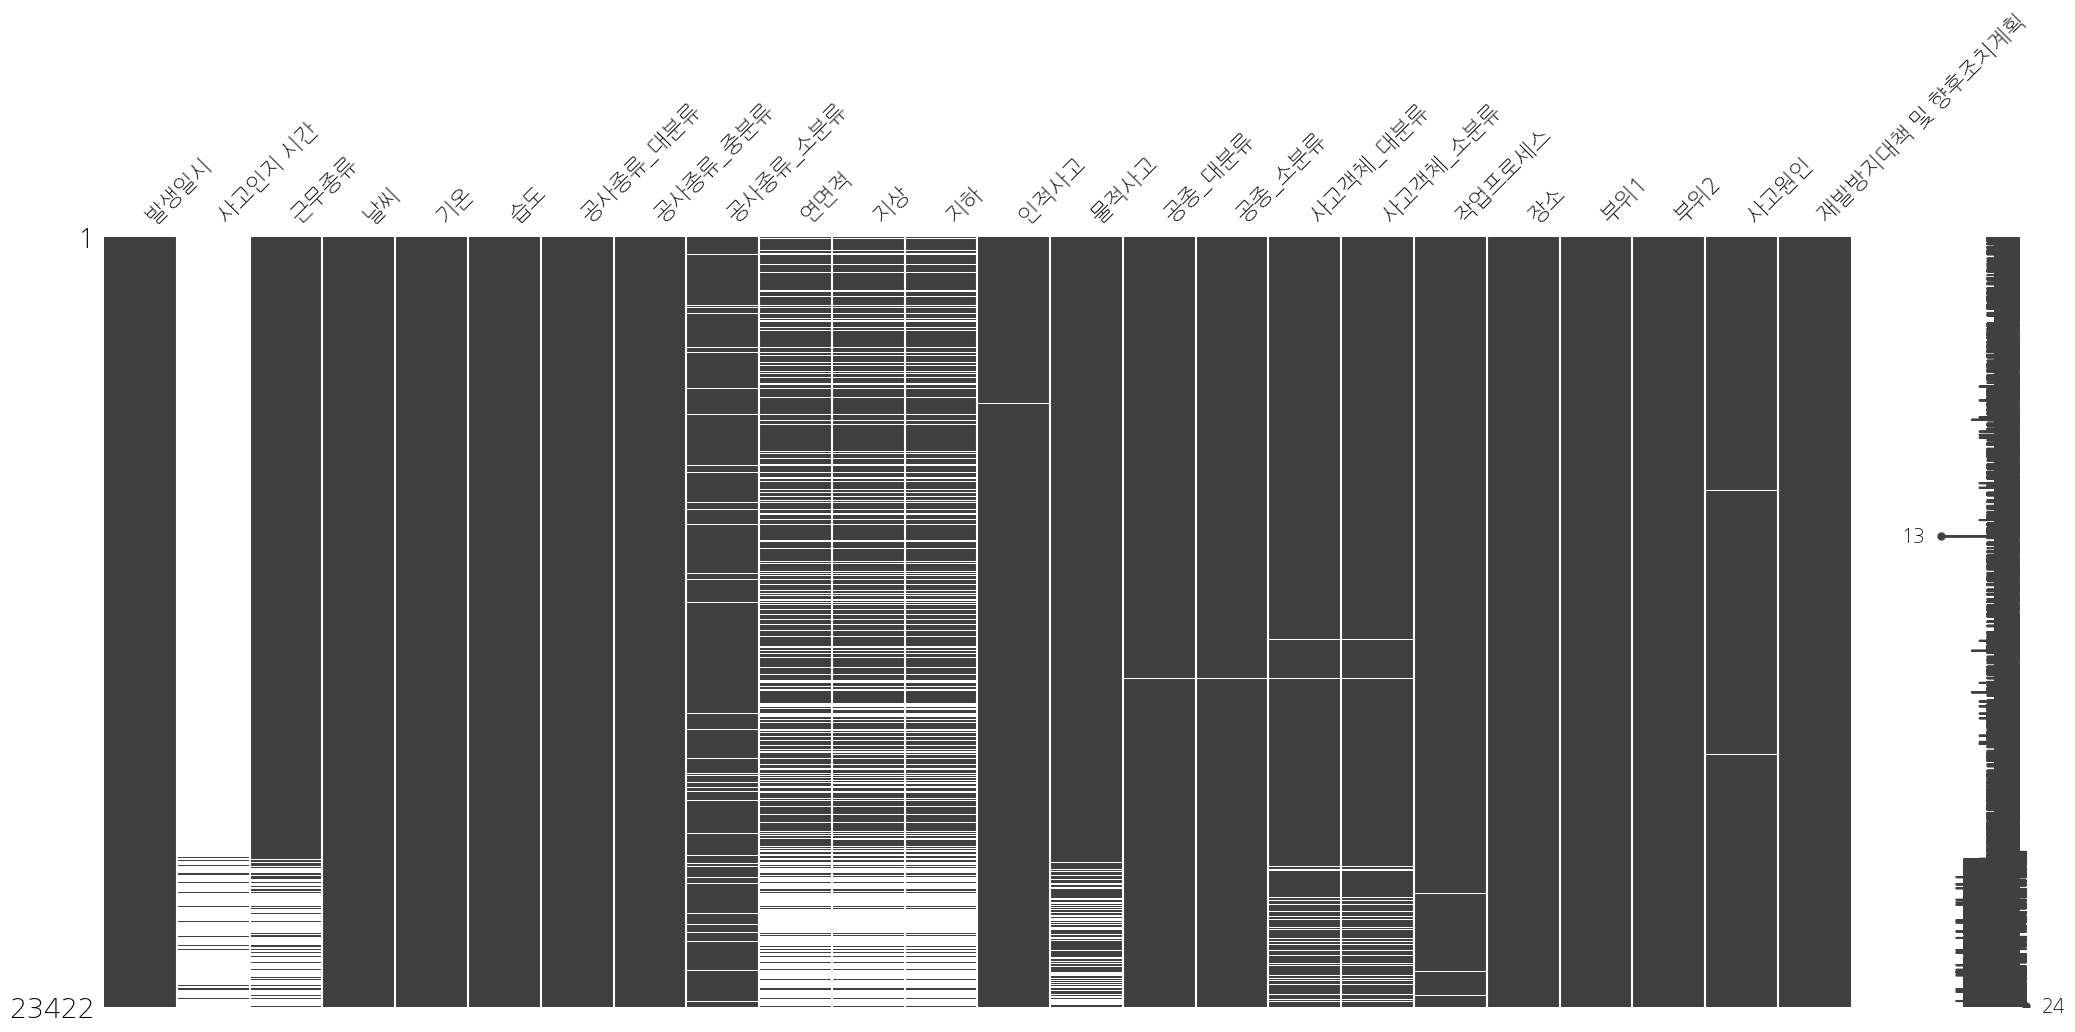

In [6]:
msno.matrix(data)

# 구현

baseline 모델 inference 한 번당 30초가 걸렸고 훈련 데이터 양이 많지 않음.

100개에 50분이므로 100~200개가 적당할 것으로 생각함

In [ ]:
def nested_stratified_sampling(
    df: pd.DataFrame,
    columns: list,
    sample_size: int,
    random_state: int = None,
) -> pd.Index:
    """
    주어진 df에서 columns 순서대로 범주의 분포가 균등하도록
    계층적으로(stratified) 샘플링을 수행한 결과의 인덱스를 반환한다.
    
    Parameters
    ----------
    df : pd.DataFrame
        입력 데이터프레임
    columns : list
        계층적으로 우선순위가 높은 순서대로 작성된 컬럼명 리스트.(선택 column은 반드시 categorical 변수)
    sample_size : int
        최종적으로 얻고 싶은 샘플의 총 개수.
    random_state : int, optional
        재현 가능한 결과를 위해 난수 시드 고정.
        
    Returns
    -------
    pd.Index
        columns에 따라 계층적으로 균등분포를 가지도록 샘플링된 인덱스
    """
    
    # 재귀 종료 조건: 더 이상 계층화할 컬럼이 없을 때
    if not columns:
        # 단순히 sample_size 만큼 랜덤 샘플링된 인덱스를 반환
        return df.sample(n=sample_size, random_state=random_state).index
    
    # 현재 재귀에서 처리해야 할 컬럼
    current_col = columns[0]

    # 카테고리별 목표 샘플 수 결정
    obj = {}
    n_cat = len(df[current_col].dropna().unique())
    remain = sample_size
    colcnt_sorted = sorted(
        df[current_col].value_counts().reset_index().to_numpy(), 
        key=lambda x: x[1]
    )
    for col, cnt in colcnt_sorted:
        n_obj = remain // n_cat
        if cnt < n_obj:
            # 실제 데이터 개수(cnt)가 목표보다 적을 경우 조정
            if cnt == 1:
                n_obj = 0
            else:
                n_obj = cnt // 2
        obj[col] = n_obj
        remain -= n_obj
        n_cat -= 1
    
    # 카테고리별로 샘플링 (인덱스 방식)
    result_indexes = []
    for c in obj.keys():
        sub_df = df[df[current_col] == c]
        # 만약 해당 범주의 데이터가 없는 경우 건너뜀
        if len(sub_df) == 0:
            continue
        sub_sample_size = obj[c]
        if sub_sample_size == 0:
            continue
            
        # 남은 컬럼에 대해 재귀적 계층 샘플링 (인덱스 받기)
        sampled_sub_idx = nested_stratified_sampling_index(
            df=sub_df,
            columns=columns[1:],  # 다음 우선순위의 컬럼들
            sample_size=sub_sample_size,
            random_state=random_state
        )
        
        result_indexes.append(sampled_sub_idx)
    
    # 각 범주별 샘플링한 인덱스를 합침 (순서, 중복 모두 유지하려면 append 사용)
    combined_index = pd.Index([])
    for idx in result_indexes:
        combined_index = combined_index.append(idx)
    
    return combined_index


In [ ]:
cols = ['근무종류', '공사종류_소분류', '공종_소분류', '작업프로세스','인적사고','물적사고']
sample_size = 100
sample_idx = nested_stratified_sampling(data, cols, sample_size, 42)
sampled = data.loc[sampled]

# 검증

In [129]:
def plot_comparing_uniform(data, sampled, col):
    # 각 범주의 비율 계산 (normalize=True로 하면 전체에서 해당 범주가 차지하는 비율)
    df_counts = data[col].value_counts(normalize=True).sort_index()
    sampled_counts = sampled[col].value_counts(normalize=True).sort_index()

    # 데이터를 합쳐서 하나의 DataFrame으로 (비율이 없는 항목은 NaN으로 처리 -> fillna(0))
    compare_df = pd.concat([df_counts, sampled_counts], axis=1).fillna(0)

    # 칼럼 이름을 보기 좋게 지정
    compare_df.columns = ['Original(DF)', 'Sampled(DF)']

    # 막대 그래프 (기본값: 'grouped bar' 형태)
    compare_df.plot(kind='bar', figsize=(8, 4))
    plt.title(f'Category Distribution in "{col}"')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)  # 카테고리 이름이 많으면 45~90 정도로 조정
    plt.legend(loc='best')
    plt.show()

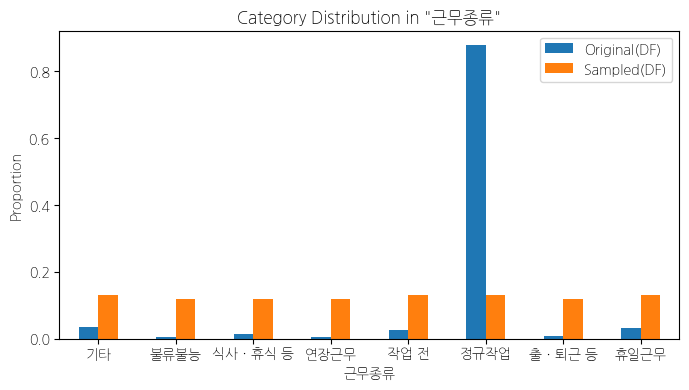

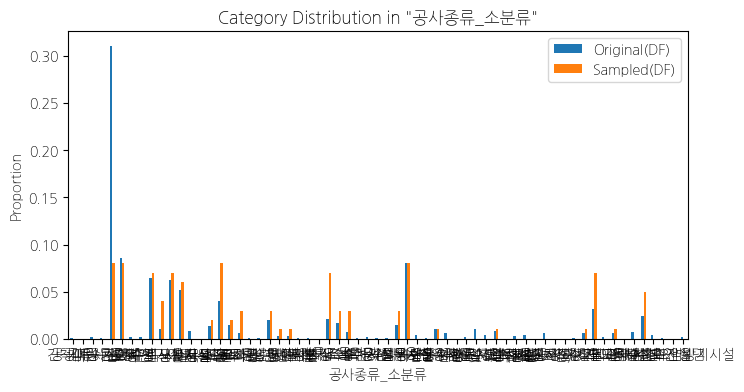

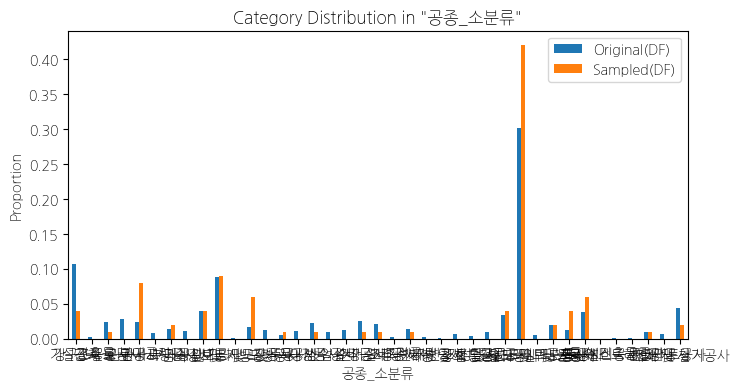

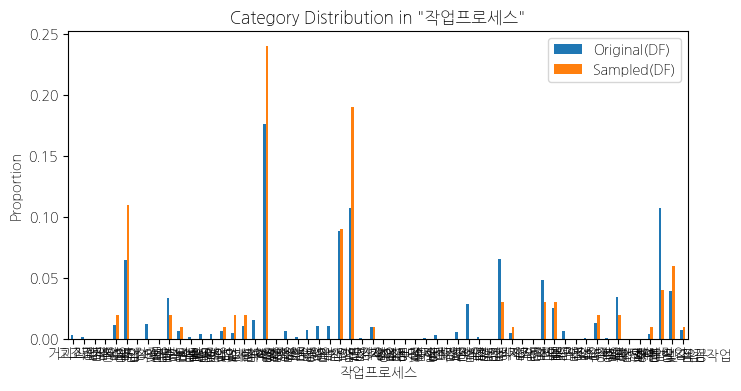

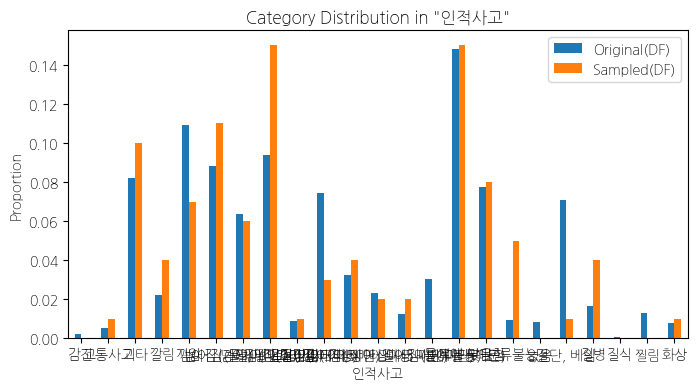

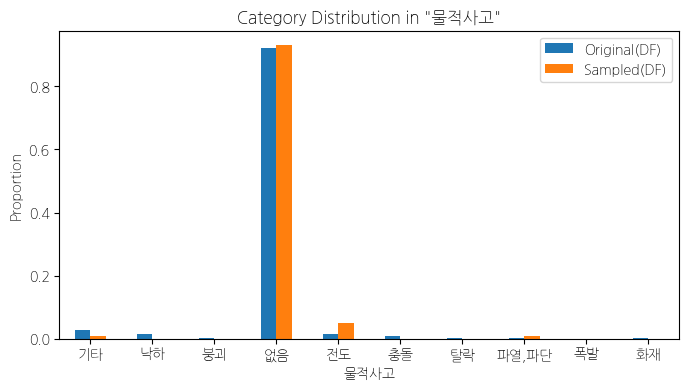

In [130]:
for col in cols:
    plot_comparing_uniform(data, sampled, col)

In [137]:
version = "sample_v1"
save_path = f"/workspace/Storage/hansoldeco3/Data/sample/{version}.csv"
pd.Series(sample_idx, name=version).to_csv(save_path, index=False)

# 결론(의견)

두 단계까진 밸런스있게 뽑았지만 그 뒤론 한계가 있었습니다. 

우선순위에 날짜를 넣지 않았는데, 날짜와 기온에서 파생된 현장 온도는 중요한 변수라고 생각됩니다.

또, 감리분야에서 건물의 높이도 중요할 것이라고 생각됩니다.

중요한 세 column을 선정하는 것이 중요할 것 같습니다.

# 계획

1. 일단 이 샘플을 검증데이터로 사용
2. 추후 검증데이터에 대한 검증